# Tutorial 1: LIFEsim

<p> Date: 21/03/2024 <br>
Hours: 2 

LIFEsim is the simulator software for the Large Interferometer For Exoplanets (LIFE). It simulates the interferometric measurement of LIFE to demonstrate the capabilities of the observatory. Coupled with on-sky source simulations, LIFEsim will infer the amount and diversity of exoplanets observable with LIFE. Inputting spectral information of exoplanets allows for a description of the spectral measurement potential of LIFE.

__Work progression:__

* Installed LIFEsim, in order to access it in my computer:

conda activate Life \
source /Users/tharacaba/new_folder/bin/activate

* Next I followed the LIFEsim documentation tutorial

## Using the GUI

In [89]:
import lifesim
from lifesim import Gui
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [67]:
Gui()

## Simulating the Search Phase

LIFEsim is capable of taking an artificial exoplanet catalog input from P-Pop (a Monte-Carlo tool to simulate exoplanet populations), calculate the signal-to-noise ratio for each planet and distribute the observation time available in the search phase to observe and detect an optimal number of exoplanets.

In [6]:
bus = lifesim.Bus()

In [7]:
#Setting up the search parameters (e.g. the collector aperture diameter, the duration of the search phase, etc.)
bus.data.options.set_scenario('baseline')

In [8]:
#Getting the data
data = requests.get('https://raw.githubusercontent.com/kammerje/P-pop/main/TestPlanetPopulation.txt')
with open('/Users/tharacaba/Desktop/Astrobiology/LIFEsim/ppop_catalog.txt', 'wb') as file:
    file.write(data.content)

In [9]:
bus.data.catalog_from_ppop(input_path='/Users/tharacaba/Desktop/Astrobiology/LIFEsim//ppop_catalog.txt')

Processed line 45884 of 45884


In [10]:
#The following will remove all A-type stars and every M-type at a distance larger than 10 pc away from earth.
bus.data.catalog_remove_distance(stype='A', mode='larger', dist=0.)
bus.data.catalog_remove_distance(stype='M', mode='larger', dist=10.)

In [11]:
#instance of the LIFEsim instrument module is created.
instrument = lifesim.Instrument(name='inst')

In [12]:
bus.add_module(instrument)

In [13]:
#create the module responsible for simulating transmission maps of a four-arm nulling interferometer and add it to the bus.
transm = lifesim.TransmissionMap(name='transm')
bus.add_module(transm)

In [14]:
#create the modules for the simulation of the astrophysical noise sources and add them to the bus.
exozodi = lifesim.PhotonNoiseExozodi(name='exo')
bus.add_module(exozodi)
localzodi = lifesim.PhotonNoiseLocalzodi(name='local')
bus.add_module(localzodi)
star_leak = lifesim.PhotonNoiseStar(name='star')
bus.add_module(star_leak)

In [15]:
#the instrument needs to be told to which modules it should connect to
bus.connect(('inst', 'transm'))
bus.connect(('inst', 'exo'))
bus.connect(('inst', 'local'))
bus.connect(('inst', 'star'))
bus.connect(('star', 'transm'))

In [16]:
#The optimizer is responsible for distributing the available observing time onto the individual stars. 
opt = lifesim.Optimizer(name='opt')
bus.add_module(opt)
ahgs = lifesim.AhgsModule(name='ahgs')
bus.add_module(ahgs)
bus.connect(('transm', 'opt'))
bus.connect(('inst', 'opt'))
bus.connect(('opt', 'ahgs'))

In [17]:
#the signal-to-noise ratio needs to be calculated for every planet in the catalog
instrument.get_snr()

100%|█████████████████████████████████████████| 535/535 [01:01<00:00,  8.63it/s]


In [18]:
#the integration time can be optimally distributed
opt.ahgs()

Number of planets detected by stellar type:
A: 0.0  F: 0.5  G: 2.8  K: 13.4  M: 21.7  -  (2.0 / 2.0) yrs observed


In [70]:
#the results can be saved 
df = bus.data.catalog
df.to_csv('results.csv')
df

,radius_p,p_orb,mass_p,ecc_p,inc_p,large_omega_p,small_omega_p,theta_p,albedo_bond,albedo_geom_vis,...,hz_in,hz_out,hz_center,habitable,snr_1h,baseline,detected,snr_current,int_time,t_slew
0,2.55899,1.21237,6.46922,0.0,0.36825,0.83082,4.28658,0.46104,0.07323,0.11134,...,0.745910,1.746354,1.246132,False,1.871119,21.85221,False,0.0,0.0,-36000.0
1,1.62557,95.32925,2.94136,0.0,0.36825,4.71701,0.58424,3.76621,0.17084,0.46161,...,0.745910,1.746354,1.246132,False,1.275610,21.85221,False,0.0,0.0,-36000.0
2,0.64641,413.44526,0.18259,0.0,0.36825,3.59078,0.90651,0.27668,0.54602,0.17279,...,0.745910,1.746354,1.246132,True,0.024712,21.85221,False,0.0,0.0,-36000.0
3,1.45874,51.20469,5.36760,0.0,2.01016,2.62388,0.47298,2.25944,0.53153,0.47091,...,0.745910,1.746354,1.246132,False,3.443921,21.85221,False,0.0,0.0,-36000.0
4,2.03712,98.57858,4.45356,0.0,2.01016,1.71757,2.04617,2.98199,0.32327,0.59087,...,0.745910,1.746354,1.246132,False,2.827395,21.85221,False,0.0,0.0,-36000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13999,0.82089,48.64809,3.00300,0.0,1.36699,3.29171,5.84907,1.15447,0.47915,0.40514,...,0.057153,0.151491,0.104322,True,0.072783,100.00000,False,0.0,0.0,-36000.0
14000,0.76631,3.78368,0.47407,0.0,2.15206,1.81751,2.27749,6.06507,0.36787,0.07721,...,0.057153,0.151491,0.104322,False,0.681642,100.00000,False,0.0,0.0,-36000.0
14001,1.29841,30.83798,1.36537,0.0,2.15206,5.07573,5.95634,4.86269,0.54785,0.21281,...,0.057153,0.151491,0.104322,True,0.163095,100.00000,False,0.0,0.0,-36000.0
14002,1.31487,184.70674,1.57873,0.0,2.15206,4.52980,5.85123,2.65320,0.54567,0.19618,...,0.057153,0.151491,0.104322,False,0.006562,100.00000,False,0.0,0.0,-36000.0


In [79]:
#A previously saved simulation can be read into LIFEsim by running
data = pd.read_csv('/Users/tharacaba/new_folder/lib/python3.8/site-packages/lifesim/gui/results.csv')
data = data.drop('Unnamed: 0', axis = 1)
data

,radius_p,p_orb,mass_p,ecc_p,inc_p,large_omega_p,small_omega_p,theta_p,albedo_bond,albedo_geom_vis,...,hz_in,hz_out,hz_center,habitable,snr_1h,baseline,detected,snr_current,int_time,t_slew
0,2.55899,1.21237,6.46922,0.0,0.36825,0.83082,4.28658,0.46104,0.07323,0.11134,...,0.745910,1.746354,1.246132,False,1.871119,21.85221,False,0.0,0.0,-36000.0
1,1.62557,95.32925,2.94136,0.0,0.36825,4.71701,0.58424,3.76621,0.17084,0.46161,...,0.745910,1.746354,1.246132,False,1.275610,21.85221,False,0.0,0.0,-36000.0
2,0.64641,413.44526,0.18259,0.0,0.36825,3.59078,0.90651,0.27668,0.54602,0.17279,...,0.745910,1.746354,1.246132,True,0.024712,21.85221,False,0.0,0.0,-36000.0
3,1.45874,51.20469,5.36760,0.0,2.01016,2.62388,0.47298,2.25944,0.53153,0.47091,...,0.745910,1.746354,1.246132,False,3.443921,21.85221,False,0.0,0.0,-36000.0
4,2.03712,98.57858,4.45356,0.0,2.01016,1.71757,2.04617,2.98199,0.32327,0.59087,...,0.745910,1.746354,1.246132,False,2.827395,21.85221,False,0.0,0.0,-36000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13999,0.82089,48.64809,3.00300,0.0,1.36699,3.29171,5.84907,1.15447,0.47915,0.40514,...,0.057153,0.151491,0.104322,True,0.072783,100.00000,False,0.0,0.0,-36000.0
14000,0.76631,3.78368,0.47407,0.0,2.15206,1.81751,2.27749,6.06507,0.36787,0.07721,...,0.057153,0.151491,0.104322,False,0.681642,100.00000,False,0.0,0.0,-36000.0
14001,1.29841,30.83798,1.36537,0.0,2.15206,5.07573,5.95634,4.86269,0.54785,0.21281,...,0.057153,0.151491,0.104322,True,0.163095,100.00000,False,0.0,0.0,-36000.0
14002,1.31487,184.70674,1.57873,0.0,2.15206,4.52980,5.85123,2.65320,0.54567,0.19618,...,0.057153,0.151491,0.104322,False,0.006562,100.00000,False,0.0,0.0,-36000.0


In [81]:
#the number of detected exoplanets in the habitable zone around M-type stars would be retrieved via
mask_mtype = bus.data.catalog.stype == 'M'
mask = np.logical_and.reduce((bus.data.catalog.detected, bus.data.catalog.habitable, mask_mtype))
result_number = mask.sum()/500 #Note the division by 500 to factor out the 500 simulated universes.
result_number

0.434

## Inovation

A correlation matrix is a statistical technique used to evaluate the relationship between two variables in a data set. The matrix is a table in which every cell contains a correlation coefficient, where 1 is considered a strong relationship between variables, 0 a neutral relationship and -1 a not strong relationship

In [86]:
#Changing all values to numerical values
data_numbers = data.columns[(data.dtypes.values != np.dtype('float64'))]
for i in range(len(data_numbers)):
    data[data_numbers[i]] = data[data_numbers[i]].astype('category').cat.codes

In [93]:
#Calculating correlation matix
data.corr()

,radius_p,p_orb,mass_p,ecc_p,inc_p,large_omega_p,small_omega_p,theta_p,albedo_bond,albedo_geom_vis,...,hz_in,hz_out,hz_center,habitable,snr_1h,baseline,detected,snr_current,int_time,t_slew
radius_p,1.000000,0.060154,0.233736,NaN,-0.011677,0.004711,-0.008127,-0.002783,-0.004725,-0.006150,...,0.015707,0.016638,0.016354,-0.218448,0.434055,-0.020561,0.130314,0.275795,-0.026006,-0.021073
p_orb,0.060154,1.000000,0.022246,NaN,0.001964,0.016534,0.003619,-0.006077,-0.005634,0.003135,...,0.011497,0.011754,0.011677,0.147501,-0.120781,-0.011824,-0.223162,-0.097501,0.001369,-0.008036
mass_p,0.233736,0.022246,1.000000,NaN,0.006376,0.006804,0.006553,-0.000637,-0.008731,-0.009113,...,-0.008800,-0.008932,-0.008892,-0.015348,0.079223,0.007142,0.001026,0.022915,0.001328,-0.004637
ecc_p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
inc_p,-0.011677,0.001964,0.006376,NaN,1.000000,-0.009826,0.005399,-0.002307,-0.000720,-0.011130,...,-0.007007,-0.007649,-0.007452,0.000448,-0.018346,0.006085,0.010616,0.006818,0.023325,0.021560
large_omega_p,0.004711,0.016534,0.006804,NaN,-0.009826,1.000000,-0.008723,0.003562,-0.007828,0.005264,...,-0.006508,-0.006412,-0.006443,-0.004013,0.004081,0.011699,-0.007497,0.011308,0.000987,0.003501
small_omega_p,-0.008127,0.003619,0.006553,NaN,0.005399,-0.008723,1.000000,-0.013251,0.008850,-0.002356,...,0.003797,0.003507,0.003596,0.007174,-0.006004,0.003229,0.001581,-0.004818,0.025383,0.021208
theta_p,-0.002783,-0.006077,-0.000637,NaN,-0.002307,0.003562,-0.013251,1.000000,0.015044,0.012196,...,0.005326,0.005290,0.005302,0.012007,0.004573,-0.007962,0.004513,-0.004055,-0.005502,0.000032
albedo_bond,-0.004725,-0.005634,-0.008731,NaN,-0.000720,-0.007828,0.008850,0.015044,1.000000,0.002917,...,0.006070,0.005824,0.005900,-0.018924,-0.086077,-0.007836,-0.087581,-0.060667,-0.004931,-0.002860
albedo_geom_vis,-0.006150,0.003135,-0.009113,NaN,-0.011130,0.005264,-0.002356,0.012196,0.002917,1.000000,...,0.011550,0.011723,0.011672,0.001733,-0.010957,-0.004004,0.001132,0.002742,0.004585,-0.003613


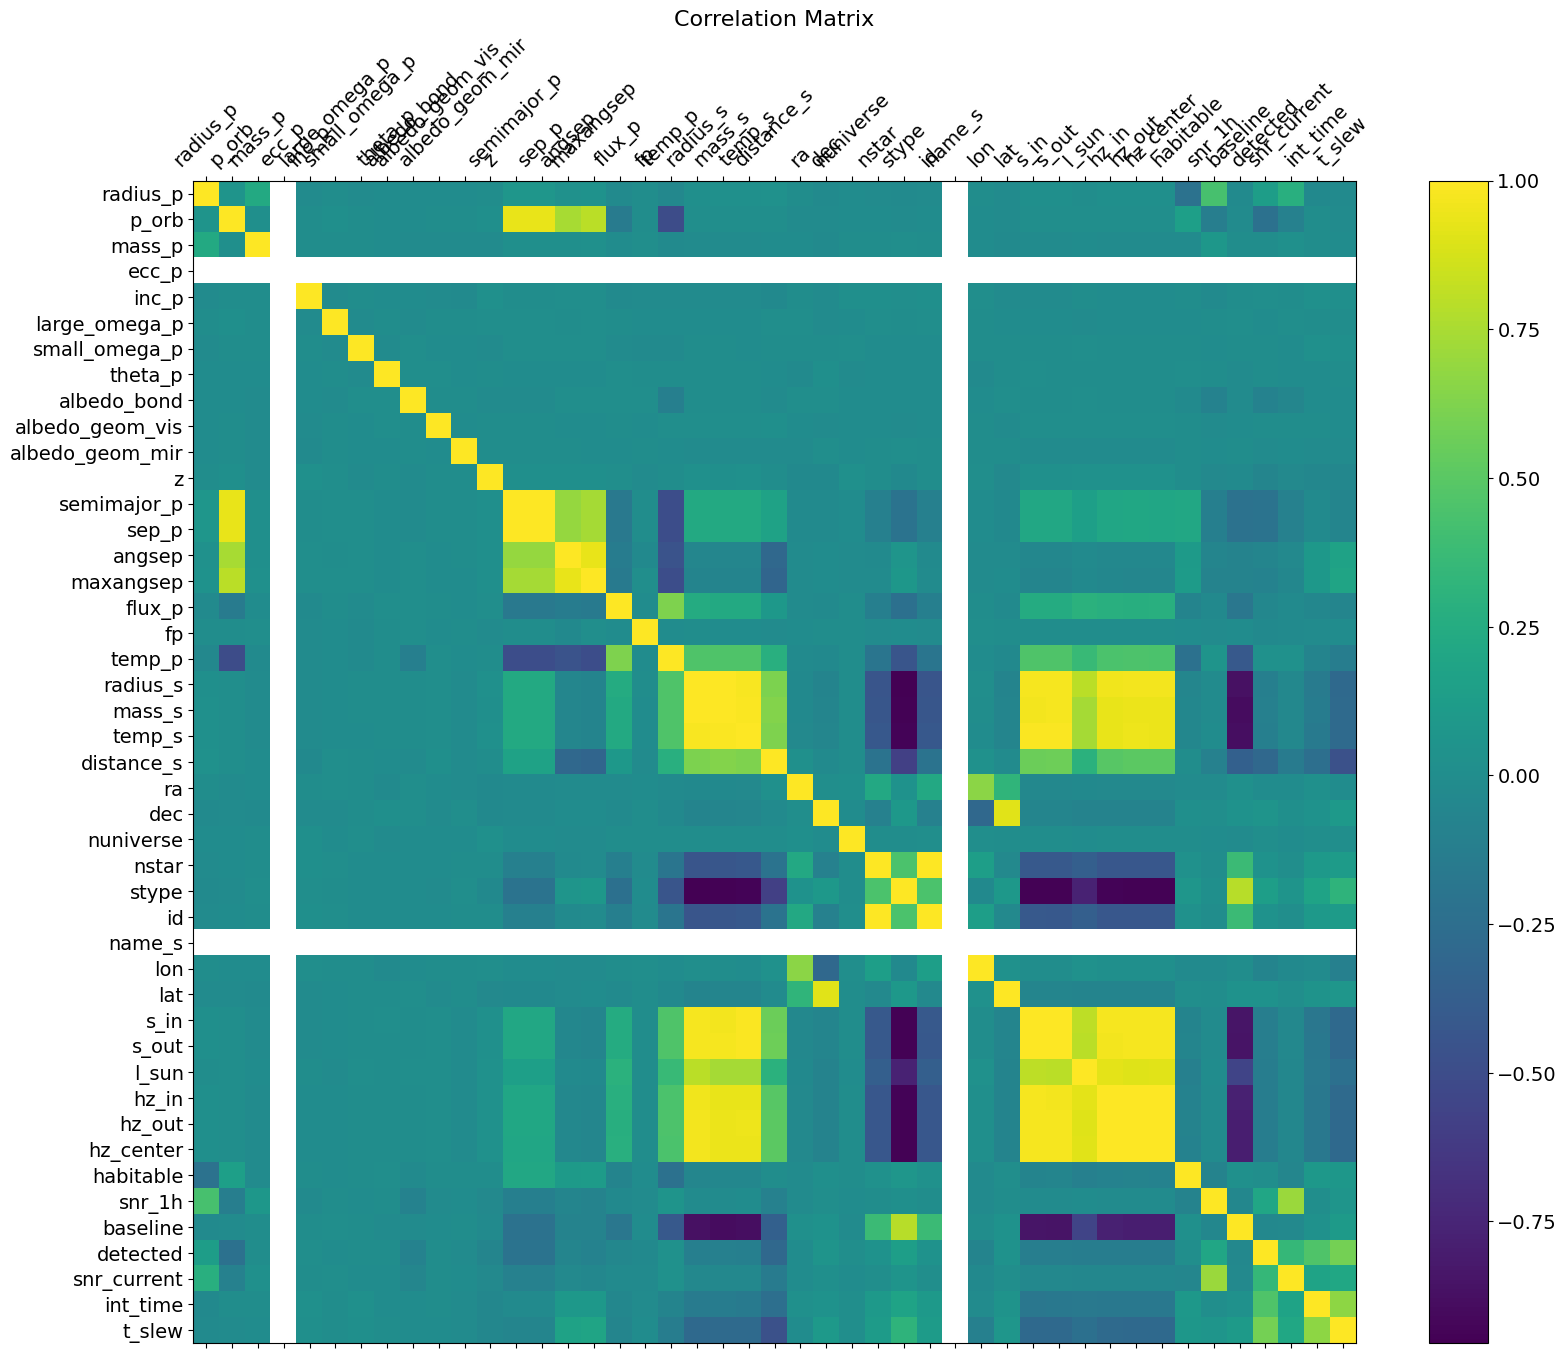

In [94]:
#Plotting correlation matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);